In [13]:
from keras import Model
from keras.layers import InputLayer, Conv2D, Dropout, BatchNormalization
from keras.layers import Concatenate, Conv2DTranspose, LeakyReLU, ReLU
from keras.layers import Multiply, Subtract

def gen_soft_unet(input_shape=(512, 128, 1), encode=5) :      # the input shape must be multiple of 64
    input_layer = InputLayer(input_shape=input_shape).input

    last_layer = input_layer
    concate_list = []
    filter_num = 16 * input_shape[2]                # set initial number of filters as 16
    
    for _ in range(encode) : 
        conv_encoder = Conv2D(filters=filter_num, kernel_size=5, strides=2, padding="same")(last_layer)
        batch_norm = BatchNormalization()(conv_encoder)
        activ_layer = LeakyReLU(alpha=0.2)(batch_norm)
        
        concate_list.insert(0, conv_encoder)
        last_layer = activ_layer
        filter_num *= 2
    
    conv_layer = Conv2D(filters=filter_num, kernel_size=5, strides=2, padding="same")(last_layer)
    activ_layer = LeakyReLU(alpha=0.2)(conv_layer)
    last_layer = activ_layer

    count = 1
    for concate_layer in concate_list : 
        filter_num /= 2

        conv_trans = Conv2DTranspose(filters=filter_num, kernel_size=5, strides=2, padding="same")(last_layer)
        merge_layer = Concatenate(axis=3)([conv_trans, concate_layer])
        conv_decoder = Conv2D(filters=filter_num, kernel_size=5, strides=1, padding="same")(merge_layer)
        batch_norm = BatchNormalization()(conv_decoder)
        activ_layer = ReLU()(batch_norm)

        if count <= 3 : 
            last_layer = Dropout(rate=0.5)(activ_layer)
        
        else : 
            last_layer = activ_layer
        
        count += 1

    conv_layer = Conv2DTranspose(filters=input_shape[2], kernel_size=5, strides=2, padding="same", activation="sigmoid")(last_layer)
    
    output_layer1 = Multiply(name="voice_extraction")([input_layer, conv_layer])
    output_layer2 = Subtract(name="music_extraction")([input_layer, output_layer1])

    return Model(inputs=[input_layer], outputs=[output_layer1, output_layer2])


Voice
Length : 312960
Sample rate : 40000
L / R : 7.82 sec


mMusic
Length : 312960
Sample rate : 40000
L / R : 7.82 sec


Merge


(1280, 490) (1280, 490) (1280, 490)
(1280, 448) (1280, 448) (1280, 448)


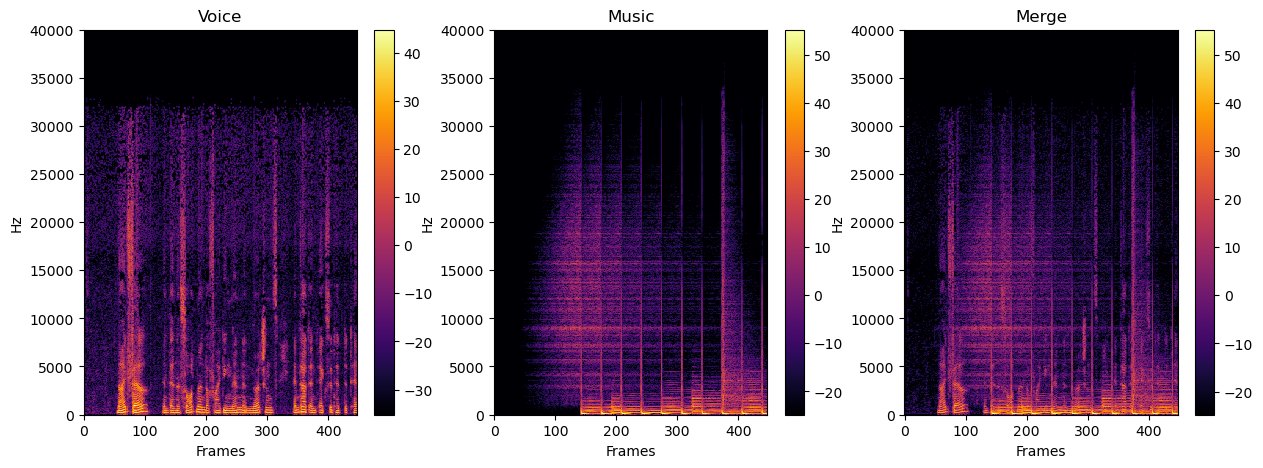

In [14]:
import librosa, os
from IPython.display import Audio

Data_path = os.path.pardir
Data_path += "/Data/kaggle_data/common-voice/"
test_data_path = Data_path + "cv-valid-train/cv-valid-train/sample-000006.mp3"

sample_rate = 40000

voice_source, sample_rate = librosa.load(test_data_path, sr=sample_rate, mono=True)

print("Voice")
print("Length : {}".format(len(voice_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(voice_source) / sample_rate))
display(Audio(voice_source, rate=sample_rate))

music_data_path = "../Data/sample/Jonas Blue - Fast Car ft. Dakota (Official Video).mp3"

music_source, sample_rate = librosa.load(music_data_path, mono=True, duration=(len(voice_source) / sample_rate), sr=sample_rate)

print("mMusic")
print("Length : {}".format(len(music_source)))
print("Sample rate : {}".format(sample_rate))
print("L / R : {:.2f} sec".format(len(music_source) / sample_rate))

display(Audio(music_source, rate=sample_rate))

print("Merge")
merge_source = voice_source + music_source

display(Audio(merge_source, rate=sample_rate))

import numpy as np
import matplotlib.pyplot as plt

# n_fft = 2 * (64 * input_shape - 1)        /       example - 1022, 1278, 1918, 2558
n_fft = 2558
D_voice_raw = librosa.stft(voice_source, n_fft=n_fft)
D_music_raw = librosa.stft(music_source, n_fft=n_fft)
D_merge_raw = librosa.stft(merge_source, n_fft=n_fft)

print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)

D_voice_raw = D_voice_raw[:,:64 * 7]
D_music_raw = D_music_raw[:,:64 * 7]
D_merge_raw = D_merge_raw[:,:64 * 7]
print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)      # input shape must be multiple of 64

# try : 
#     del fig, axes
# finally : 
#     pass

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for ax, D, title in zip(axes, [np.abs(D_voice_raw), np.abs(D_music_raw), np.abs(D_merge_raw)], ["Voice", "Music", "Merge"]) : 
    S_db = librosa.amplitude_to_db(D)
    cb = librosa.display.specshow(S_db, x_axis="frames", y_axis="fft", sr=sample_rate * 2, ax=ax, cmap="inferno")
    ax.set_title(title)
    plt.colorbar(cb)

In [15]:
print(D_voice_raw.shape, D_music_raw.shape, D_merge_raw.shape)
print(n_fft)

(1280, 448) (1280, 448) (1280, 448)
2558


In [16]:
import numpy as np
def complex_to_polar(array) : 
    r = np.abs(array)
    angle = np.angle(array)
    
    result_array = np.zeros(shape=(*array.shape, 2), dtype=array[...,0].real.dtype)
    result_array[..., 0] = r
    result_array[..., 1] = angle
    
    return result_array

polar_voice = complex_to_polar(D_voice_raw)
polar_music = complex_to_polar(D_music_raw)
polar_merge = complex_to_polar(D_merge_raw)

print(polar_voice.shape, polar_music.shape, polar_merge.shape)

def polar_to_complex(array) : 
    from numpy import cos, sin
    
    r = array[..., 0]
    theta = array[..., 1]

    real_part = r * cos(theta)
    imag_part = r * sin(theta)
    
    complex_array = real_part + imag_part * 1j

    return complex_array

(1280, 448, 2) (1280, 448, 2) (1280, 448, 2)


In [17]:
test_model = gen_soft_unet(input_shape=polar_merge.shape, encode=4)
test_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1280, 448,   0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 640, 224, 32  1632        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 640, 224, 32  128        ['conv2d_11[0][0]']              
 ormalization)                  )                                                           

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

patience = 50
early_stop = EarlyStopping(monitor="loss", patience=patience, verbose=True, restore_best_weights=True, min_delta=0.01)
check_point = ModelCheckpoint(filepath="./soft_U_Net_checkpoint/", monitor="loss", verbose=True, save_best_only=True, save_weights_only=True)
callbacks = [early_stop, check_point]
callbacks = [early_stop]

In [ ]:
test_model.compile(optimizer="adam", loss="mae", metrics=["mse", "mae"])
history = test_model.fit(
    x=polar_merge.reshape((1, *polar_merge.shape)), y=[polar_voice.reshape((1, *polar_voice.shape)), polar_music.reshape((1, *polar_music.shape))],
    batch_size=1, epochs=patience * 10, verbose=2, callbacks=callbacks
)
test_model.save(filepath="./U_Net_checkpoint/checkpoint.h5")

In [20]:
print(history.history.keys())
# multiply : voice
# subtract : music

dict_keys(['loss', 'voice_extraction_loss', 'music_extraction_loss', 'voice_extraction_mse', 'voice_extraction_mae', 'music_extraction_mse', 'music_extraction_mae'])


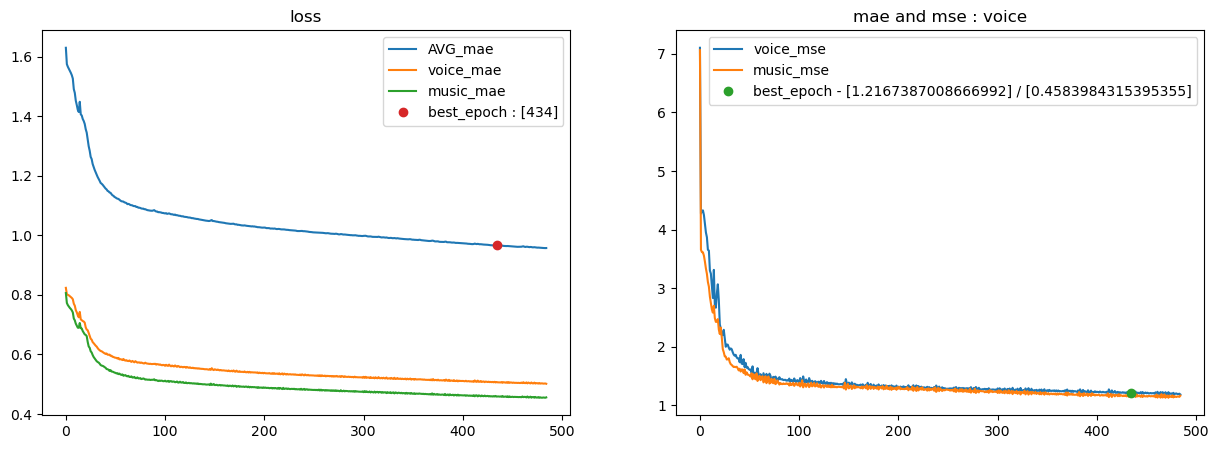

In [21]:
import matplotlib.pyplot as plt

epoch = history.epoch
best_epoch = epoch[-1] - patience

loss = history.history["loss"]

voice_extraction_mae = history.history["voice_extraction_mae"]
voice_extraction_mse = history.history["voice_extraction_mse"]

music_extraction_mae = history.history["music_extraction_mae"]
music_extraction_mse = history.history["music_extraction_mse"]

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

axes[0].plot(epoch, loss, label="AVG_mae")
axes[0].plot(epoch, voice_extraction_mae, label="voice_mae")
axes[0].plot(epoch, music_extraction_mae, label="music_mae")
axes[0].plot(best_epoch, loss[best_epoch], 'o', label="best_epoch : [{}]".format(best_epoch))
axes[0].legend()
axes[0].set_title("loss")

axes[1].plot(epoch, voice_extraction_mse, label="voice_mse")
axes[1].plot(epoch, music_extraction_mse, label="music_mse")
axes[1].plot(
    best_epoch, voice_extraction_mse[best_epoch], 'o',
    label="best_epoch - [{}] / [{}]".format(voice_extraction_mse[best_epoch], music_extraction_mae[best_epoch])
)
axes[1].legend()
axes[1].set_title("mae and mse : voice")

plt.show()

In [22]:
pred_polar = test_model.predict(polar_merge.reshape((1, *polar_merge.shape)), batch_size=1)
pred_polar_voice, pred_polar_music = pred_polar
print(pred_polar_voice.shape, pred_polar_music.shape)
pred_voice = polar_to_complex(pred_polar_voice)
pred_music = polar_to_complex(pred_polar_music)
pred_voice = pred_voice.reshape((pred_voice.shape[1:3]))
pred_music = pred_music.reshape((pred_music.shape[1:3]))
print(pred_voice.shape, pred_music.shape)

1/1 [==============================] - 0s 251ms/step
(1, 1280, 448, 2) (1, 1280, 448, 2)
(1280, 448) (1280, 448)


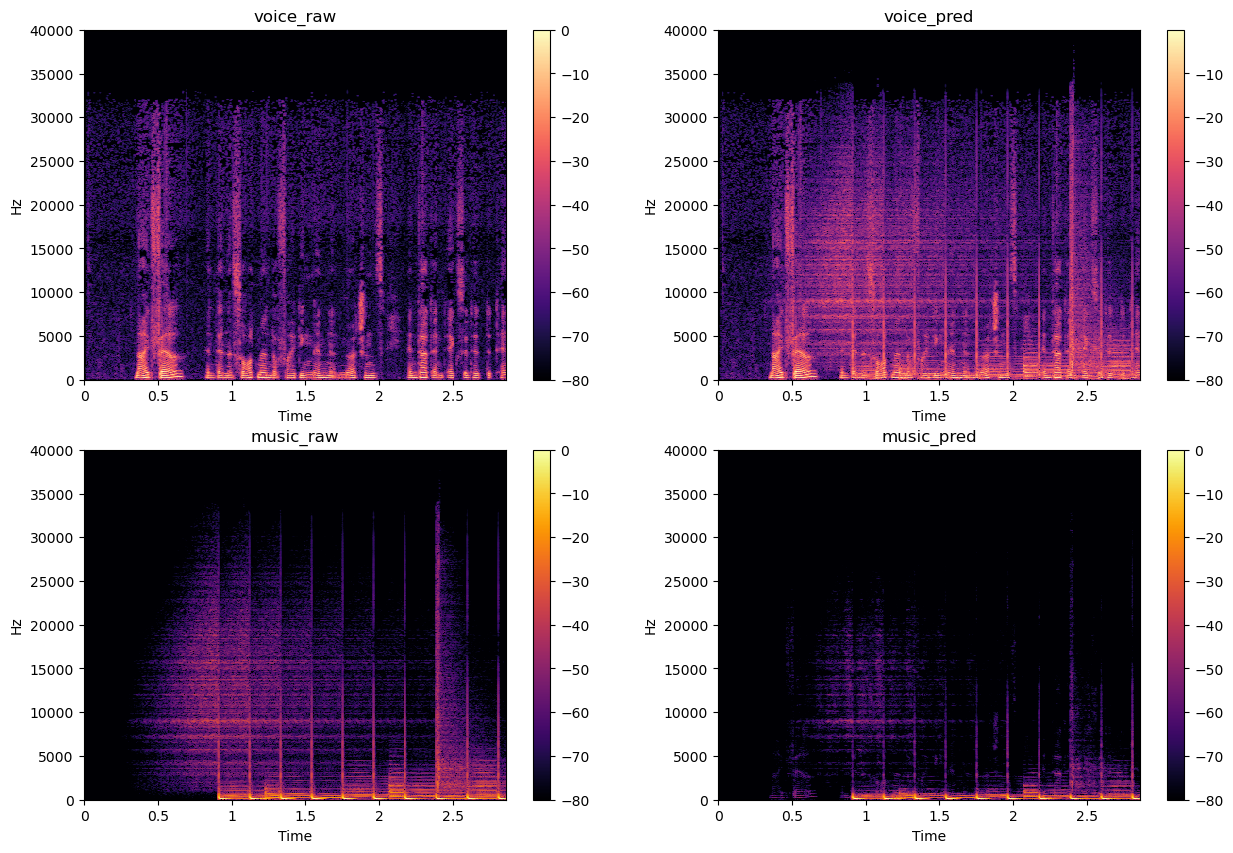

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for ax, data in zip(axes[0], [np.abs(D_voice_raw), np.abs(pred_voice)]) : 
    D_db = librosa.amplitude_to_db(data, ref=np.max)
    cb = librosa.display.specshow(D_db, x_axis="time", y_axis="fft", sr=sample_rate * 2, ax=ax)
    plt.colorbar(cb)

D_music_temp = librosa.amplitude_to_db(np.abs(D_music_raw), ref=np.max)
cb = librosa.display.specshow(D_music_temp, x_axis="time", y_axis="fft", sr=sample_rate * 2, ax=axes[1,0], cmap="inferno")
plt.colorbar(cb)

D_compare = librosa.amplitude_to_db(np.abs(pred_music), ref=np.max)
cb = librosa.display.specshow(D_compare, x_axis="time", y_axis="fft", sr=sample_rate * 2, ax=axes[1,1], cmap="inferno")
plt.colorbar(cb)

axes[0,0].set_title("voice_raw")
axes[1,0].set_title("music_raw")
axes[0,1].set_title("voice_pred")
axes[1,1].set_title("music_pred")

plt.show()

In [24]:
merge_inverse = librosa.istft(D_merge_raw, n_fft=n_fft)
voice_inverse = librosa.istft(D_voice_raw, n_fft=n_fft)
pred_inverse_voice = librosa.istft(pred_voice, n_fft=n_fft)
pred_inverse_music = librosa.istft(pred_music, n_fft=n_fft)

print(merge_inverse.shape, voice_inverse.shape, pred_inverse_voice.shape, pred_inverse_music.shape)
display(Audio(merge_inverse, rate=sample_rate))
display(Audio(voice_inverse, rate=sample_rate))
display(Audio(pred_inverse_voice, rate=sample_rate))
display(Audio(pred_inverse_music, rate=sample_rate))

(285633,) (285633,) (285633,) (285633,)
